# Cat or Dog?

## Predict whether picture is of a cat or a dog
- skills used
  - binary classification
  - use of validation set
  - convolutional neural network
  - image preprocessing
  - intermediate checking
  - image manipulation to create larger training set
  - import of pretrained models

In [1]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./cats_and_dogs_filtered.zip

In [1]:
import os

base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [2]:
# cat train pics
train_cats_dir = os.path.join(train_dir, 'cats')

# dog train
train_dogs_dir = os.path.join(train_dir, 'dogs')

# cat validation
validation_cats_dir = os.path.join(validation_dir, 'cats')

# dog vaildation
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

print('\n')

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.843.jpg', 'cat.771.jpg', 'cat.616.jpg', 'cat.288.jpg', 'cat.796.jpg', 'cat.246.jpg', 'cat.333.jpg', 'cat.602.jpg', 'cat.9.jpg', 'cat.722.jpg']


['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# output of 4x4
nrows = 4
ncols = 4

# index for iterating over images
pic_index = 0

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


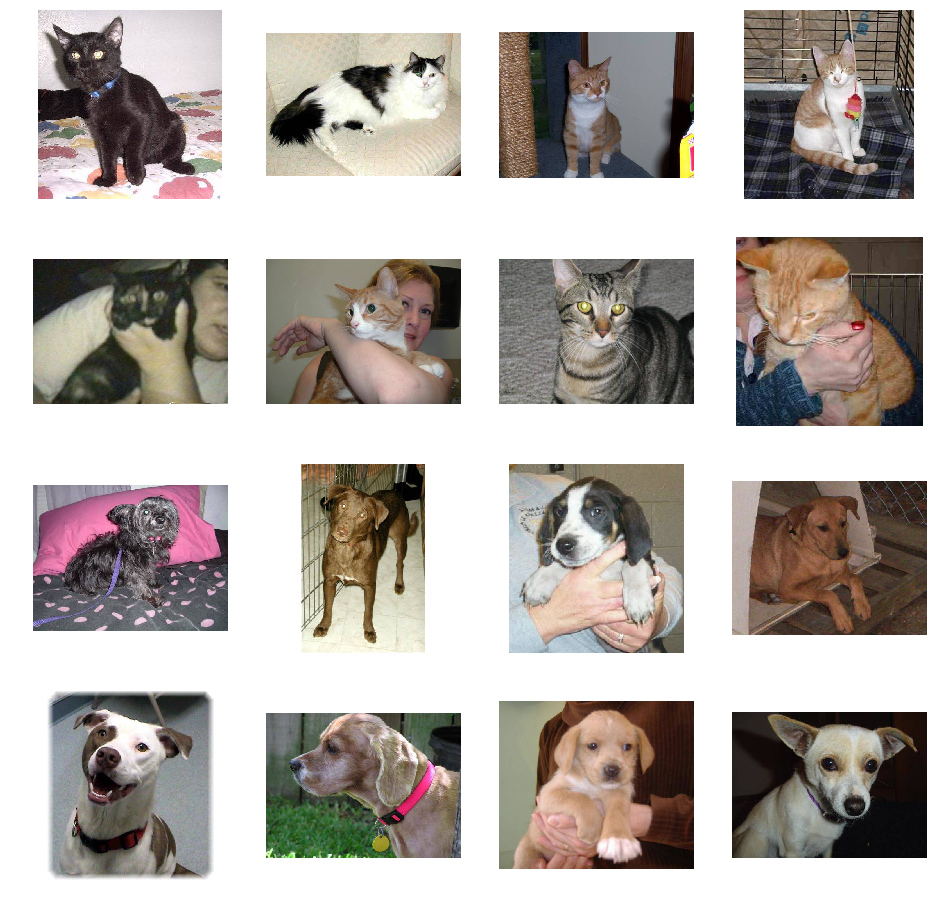

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

ConvNet will take 150x150 color images, and resizing will be done on all to match this size

Stack 3 modules: <br/>
1) Convolution to take 3x3 windows <br/>
   first convolution takes 16, next 32, next 64  <br/>
2) ReLu  <br/>
3) MaxPooling to take 2x2  <br/>

A common configuration for image classification.  
Only 1000 images, so 3 modules keeps model small and reduces overfitting

## Model Setup

In [7]:
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras import backend as K

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# configure TF backend
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

In [9]:
# input feature map is 150x150x3
# 150's for the image size, and 3 for the 3 colors channels RGB
img_input = layers.Input(shape=(150, 150, 3))

In [11]:
# first conv extracts 16 filters that are 3x3
# convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# next convolutions take 32 and 64 respectively, still with 2x2 maxpool
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Binary classification problem, so use sigmoid activation.
Output is therefore scalar between 0 and 1, probability of current image being Class 1 as opposed to 0

In [12]:
# flatten feature map to 1-dim tensor
x = layers.Flatten()(x)

# Then create fully connected layer with ReLu and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

In [13]:
# output layer, single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

Model is:

input: input feature map

output: input feature map + steacked conv/maxpool layers + fully connected layer + sigmoid output layer


In [14]:
model = Model(img_input, output)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
__________

'Output Shape' column shows how feature map size evolves in each layer. The convolution layers reduce the feature maps due to padding, each pooling layer halves the feaature map.

Loss fuction is 'binary_crossentropy' because it is binary classification with sigmoid final activation

Optimizer is rmsprop, learning rate is 0.001

Adam and Adagrad would also be valid here

Metric of accuracy

In [16]:
from keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

## Data Preprocessing

Use `ImageDataGenerator` to conver pictures to tensors.  

`.flow` creates a generator for image batches

One generator for training set, one for validation set.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
# Rescale all to 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# generate batch of 20 images, resize to 150x150, class_mode of 'binary' labels

# training set
train_generator = train_datagen.flow_from_directory(
        train_dir, # source directory
        target_size=(150, 150),  # resizing
        batch_size=20,
        class_mode='binary') # binary labels because loss function is binary_crossentropy

Found 2000 images belonging to 2 classes.


In [21]:
# validation set
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


## Training
Training uses all 2000 images, 15 epochs. Validate on all 1000 images

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
 - 30s - loss: 0.7150 - acc: 0.5745 - val_loss: 0.6379 - val_acc: 0.6130
Epoch 2/15
 - 29s - loss: 0.6308 - acc: 0.6630 - val_loss: 0.6025 - val_acc: 0.6920
Epoch 3/15
 - 29s - loss: 0.5456 - acc: 0.7285 - val_loss: 0.5733 - val_acc: 0.7050
Epoch 4/15
 - 29s - loss: 0.4616 - acc: 0.7835 - val_loss: 0.5662 - val_acc: 0.7090
Epoch 5/15
 - 29s - loss: 0.3703 - acc: 0.8315 - val_loss: 0.6647 - val_acc: 0.6950
Epoch 6/15
 - 29s - loss: 0.2721 - acc: 0.8915 - val_loss: 0.6000 - val_acc: 0.7120
Epoch 7/15
 - 30s - loss: 0.1915 - acc: 0.9280 - val_loss: 0.9819 - val_acc: 0.6880
Epoch 8/15
 - 29s - loss: 0.1318 - acc: 0.9515 - val_loss: 1.1557 - val_acc: 0.7050
Epoch 9/15
 - 29s - loss: 0.0774 - acc: 0.9745 - val_loss: 1.1266 - val_acc: 0.7400
Epoch 10/15
 - 29s - loss: 0.0876 - acc: 0.9695 - val_loss: 1.2015 - val_acc: 0.7270
Epoch 11/15
 - 29s - loss: 0.0695 - acc: 0.9825 - val_loss: 1.3515 - val_acc: 0.7070
Epoch 12/15
 - 29s - loss: 0.0505 - acc: 0.9865 - val_loss: 1.4834 - val_a

## Visualizing Intermediate Results

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


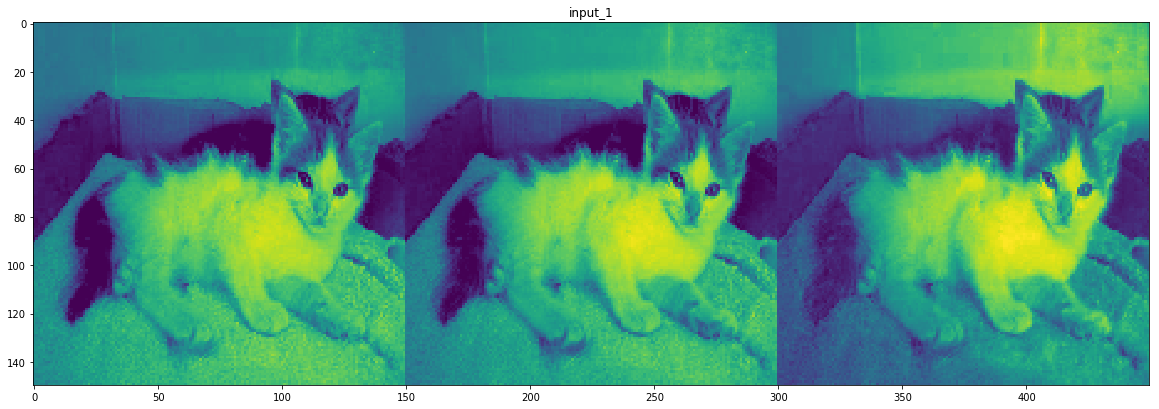

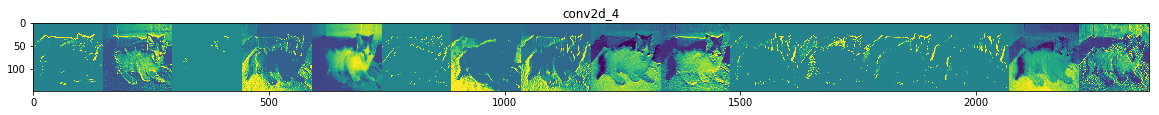

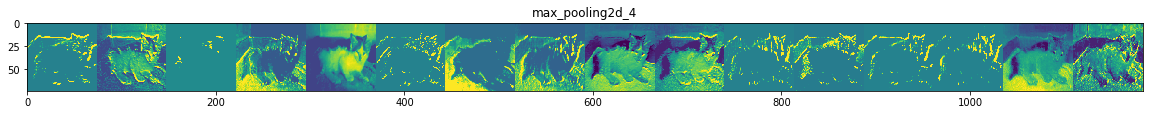

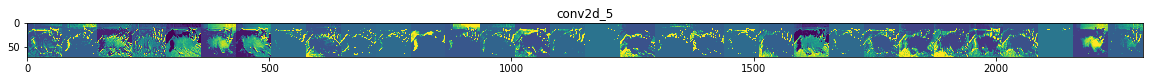

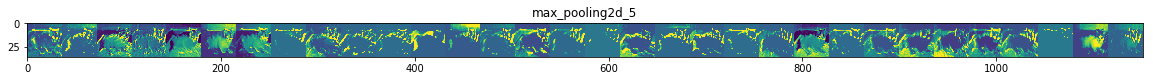

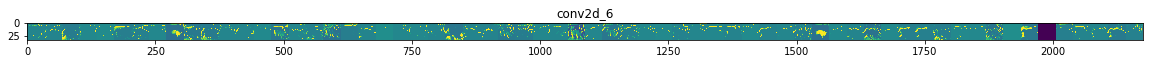

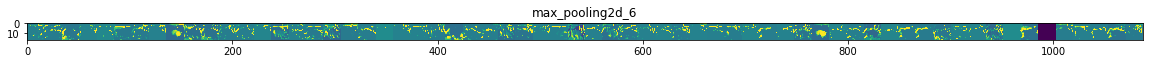

In [23]:
import numpy as np
import random
from keras.preprocessing.image import img_to_array, load_img

# new model that outputs intermediate representations for all layers in the previous model.
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(img_input, successive_outputs)

# random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Run the random image through the network, and capture intermediate results
successive_feature_maps = visualization_model.predict(x)

# get layer names for plot
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # only get conv/maxpool layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # tile our images in matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # horizontal grid
        
    # display   
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.
These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. A convnet (or a deep network in general) can be thought of as an information distillation pipeline.

# Model Evaluation

Text(0.5,1,'Training and validation loss')

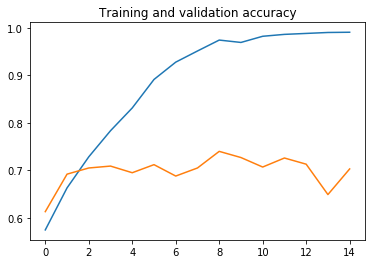

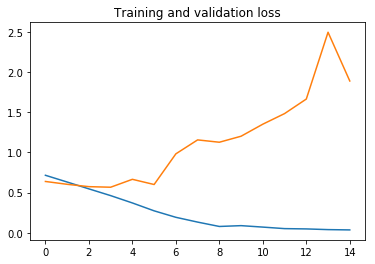

In [24]:
# Get a list of accuracy results on training and test data sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Get the loss results
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Blue is training, Orange is validation

Accuracy plot shows severe overfitting for later epochs on the training set, reaching 100% while the validation set stays at ~70%. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.  There are only 2000 training set images, which induces overfitting.

In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

## Data Augmentation
Create a larger training set by applying random transformations so that the model never sees the same model twice, therefore increasing generalization and reducing overfitting

In [1]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40, # range of degrees to randomly rotate
      width_shift_range=0.2, # range to randomly translate horiontally
      height_shift_range=0.2, # and vertically
      shear_range=0.2, # apply shear
      zoom_range=0.2, # apply random zooming
      horizontal_flip=True, # randomly flipping half of the images horizontally.
      fill_mode='nearest') # what to do with any empty space after augmentation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# same as above
import os
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# cat train pics
train_cats_dir = os.path.join(train_dir, 'cats')
# dog train
train_dogs_dir = os.path.join(train_dir, 'dogs')
# cat validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
# dog vaildation
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

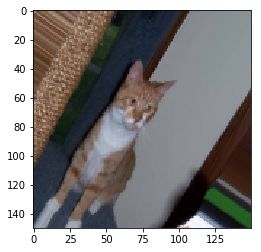

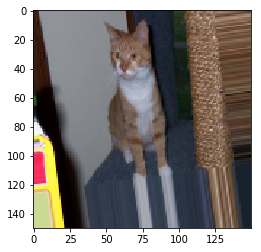

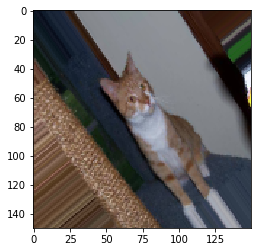

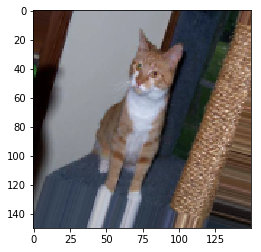

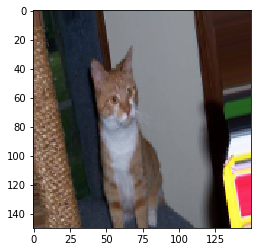

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import array_to_img, img_to_array, load_img
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150)) 
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  #

# The .flow() command below generates batches of randomly transformed images
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

This is one of the funniest things I have seen in my life.